<a href="https://colab.research.google.com/github/yvesheri4/short-pulse-electron-beam-python/blob/main/Particle_motion_6_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper 1 - Space charge effects

____

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import joypy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.datasets import load_iris
import os
import pandas as pd
from glob import glob
import seaborn as sns

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from matplotlib.ticker import MaxNLocator

import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import constants
import seaborn as sns
eps_0 = constants.epsilon_0
from matplotlib import cm
# import scienceplots
import matplotlib.pyplot as plt
import matplotlib as mpl

# plt.style.use(['no-latex'])

size = 24
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':2.75,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

### Particles

In [4]:
import numpy as np
from scipy import constants as cst

# Define the particle class
class Particle:
    def __init__(self, mass,charge, index):
        self.mass = mass
        self.i = index
        self.charge = charge
        self.r = np.zeros((1), dtype='float64')
        self.v = np.zeros((1), dtype='float64')

    def initPos(self, x):
        self.r = x

    def initSpeed(self, vx):
        self.v = vx

    def Heri_push(self, dt, E):
        temp = self.v
        self.v += 1.5*E*dt
        self.r += 3*(self.v+temp)*dt/2

### Functions

#### Particles related functions

In [ ]:
def Create_Particle_list(mass,charge):
    List = []
    for i in range(len(charge)):
        List.append(Particle(mass[i],charge[i],i+1))
    return List

def Init_Particle_list(List,InitPos,InitSpeed):
    for i in range(len(List)):
        List[i].initPos(InitPos[i])
        List[i].initSpeed(InitSpeed[i])
    return List


#### Fields related functions

In [ ]:
def Electric_Field(List,V0,d,t,Dt):
    N_inj = 1+int(t/Dt)
    if N_inj > len(List):
        N_inj = len(List)
    E = np.zeros(len(List))
    sum1 = 0
    List2 = []
    for j in range(N_inj):
        if List[j].r < 1 and List[j].r >=0:
            sum1 += (List[j].charge*List[j].r)
            List2.append(List[j])
    for j in range(len(List2)):
        sum2 = 0
        for i in range(j):
            sum2 += List2[i].charge
        E[List2[j].i-1] = 1 + (sum1 - sum2 + 0.5*List2[j].charge)
    return E

def Current_density(Vel,rho):

    len_t = Vel.shape[0]
    N_sheet = Vel.shape[1]
    J = np.zeros(len_t)

    for i in range(len_t):
        sum1 = 0
        for j in range(N_sheet):
            sum1 += 3*Vel[i][j]*rho[j]
        J[i] = sum1

    return J

#### Simulations related

In [ ]:
def Simulation(t_sim,Sys_Params,InitCond,k=100):

    time = np.linspace(0,t_sim,k)
    dt = time[1]-time[0]

    InitPos,InitSpeed = InitCond
    Dt,mass,charge,V0,d = Sys_Params

    List_part = Create_Particle_list(mass,charge)

    List_part = Init_Particle_list(List_part,InitPos,InitSpeed)
#     print(List_part[0].r)

    position = np.zeros([len(time),len(List_part)])
    velocity = np.zeros([len(time),len(List_part)])
    E_field = np.zeros([len(time),len(List_part)])

    count = 0

    for t in time:
        E = Electric_Field(List_part,V0,d,t,Dt)
        E_field[count] = E

        for j in range(len(List_part)):
            position[count][j] = List_part[j].r
            velocity[count][j] = List_part[j].v

            if List_part[j].r < 1 and List_part[j].r >= 0:
                List_part[j].Heri_push(dt,E[j])
            else:
                List_part[j].v = 0
        count += 1
    return position,velocity,E_field

def distorsion(position,time,Dt,M):
    t_init = Dt*(M-1)
    i = 0
    while  position[i,0] < 1:
        i +=1
    j = 0
    while  position[j,-1] < 1:
        j +=1
    t_final = time[j] - time[i]
    Distorsion = t_final / t_init
    return Distorsion

def Norm_J_crit_s(Xcl):
    return (3/4)/Xcl

def Norm_J_crit_e(Xcl):
    T1 = 2*(1-np.sqrt(1-(3/4)*Xcl**2))/Xcl**3
    return T1

def limit_charge(T0,Params_sys,ini_conds,iterations):
    tol = 1e-7
    Indicator = False
    position,velocity,E_field = Simulation(T0,Params_sys,ini_conds,iterations)
    if (abs(position[-1,:] - position[0,:]) < tol ).any():
        Indicator = True
    return Indicator

# def sheets_spacing(mass,) = lambda e,E,m,dt: 0.5*(e*E/m)*(dt**2)

Time_transit = lambda Vg,d : np.sqrt(2*d/(cst.e*Vg/(d*cst.m_e)))

Sigma_1 = lambda Vg,d : -cst.epsilon_0*Vg/d

#### Plots

In [ ]:
def plots_shape_phase_mult(position,velocity,E_field,rho,n=2):

#     lag = int(len(position[0])/n)

    lag = 5000

    len_rho = len(rho)

    psum = [6.2665706768411304,12.499856013286099,17.94732608456735,21.721125396120463]

    for i in range(1,n+2):
        if i == n:
            lag = lag - 1

        plt.figure(figsize=(10,2.75))

#         print(i*lag*Dt_b*Tcl/T0)


        for j in range(len_rho):

            shape = np.array([position[j][lag*i],rho[j]])
            field = np.array([position[j][lag*i],E_field[j][lag*i]])
            phase = np.array([position[j][lag*i],velocity[j][lag*i]])

            plt.subplot(1,3,1)
            plt.title("Pulse profile")
            plt.plot(shape[0],shape[1],lw=1,label=f"$\\rho/\\rho^*$ = {int(100*(j+1)*0.25)}%")
#             plt.plot(shape[0],shape[1],lw=5,label=f"a = {round(1/psum[j],2)}, b= {2*((j+1)*2.5)**2}")

#             plt.xlabel("Position")
            plt.ylabel("Charge")
            plt.legend(fontsize=8)
            plt.xlim(0,1)
        ######################################################


            K = np.array([0])
            A = np.array([1])
            E_K = np.array([field[1][-1]])
            E_A = np.array([field[1][0]])
            con1 = np.concatenate((A, field[0],K))
            con2 = np.concatenate((E_A, field[1],E_K))

            plt.subplot(1,3,2)
            plt.title("E field")
#             plt.plot(field[0],field[1],lw=3)
            plt.plot(con1,con2,lw=1)
#             plt.xlabel("Position")
            plt.ylabel("E")
            plt.xlim(0,1)

        ######################################################

            plt.subplot(1,3,3)
            plt.title("Phase-space profile")
            plt.plot(phase[0],phase[1],lw=1)
#             plt.xlabel("Position")
            plt.ylabel("Velocity")
            plt.xlim(0,1)

            plt.tight_layout(pad=.3)

#         plt.savefig(f'snapshots_sq{j}.jpg', dpi=400)
        plt.show()

In [ ]:
# position_sq.shape

____

In [ ]:
def gaussian_profile(tp,M):
  sig2 = tp **2/np.log(256)
  sig = np.sqrt(sig2)
  t = np.linspace(-3.5*sig, 3.5*sig, M)
  prof_ = np.exp(-0.5*((t)**2) /sig2 )
  prof_ /= np.sum(prof_)
  return prof_

def trapezoid_profile(tp,M):
  start_time = 0
  rise_time = 0.15*tp
  fall_time = 0.15*tp

  # End time of the trapezoidal pulse
  end_time = start_time + rise_time + tp + fall_time

  t = np.linspace(0, end_time, M)

  # Initialize the pulse array
  pulse = np.zeros_like(t)

  # Calculate indices for rise, top, and fall segments
  rise_end = start_time + rise_time
  top_end = rise_end + tp
  fall_start = top_end
  fall_end = fall_start + fall_time

  # Rise segment
  pulse[(t >= start_time) & (t < rise_end)] = (
       (t[(t >= start_time) & (t < rise_end)] - start_time) / rise_time
  )
  # Top segment (FWHM width)
  pulse[(t >= rise_end) & (t < top_end)] = 1

  # Fall segment
  pulse[(t >= fall_start) & (t < fall_end)] = (
       (1 - ((t[(t >= fall_start) & (t < fall_end)] - fall_start) / fall_time))
  )
  return pulse / np.sum(pulse)

Time_CL = lambda Vg,d : 3*d/np.sqrt(2*cst.e*Vg/cst.m_e)

def pulse_profile(tp,M,Type = 'square'):
    Type = Type.lower()
    if Type == 'square':
        return np.ones(M)/M
    if Type == 'gauss':
        return gaussian_profile(tp,M)
    if Type == 'trapezoidal':
        return trapezoid_profile(tp,M)
    else:
        return print('Profile not recognized')

# Injection Simulation

## Parameters

In [ ]:
V0 = 30e3
d = 1.5e-3
M = 200
Tcl = Time_CL(V0,d)
kp = .1
fp = 1
tpulse = kp*Tcl     # Full Width at Half Maximum
t0 = tpulse/2       # Center of the pulse

iterations = 2000
Dt = kp/M

ini_pos = np.zeros(M)
ini_speed = np.zeros(M)
ini_conds = [ini_pos,ini_speed]
time = np.linspace(0, 2,iterations)

In [ ]:
#_______________________________
plt.rc('font', family='serif')
Ga_charge = pulse_profile(tpulse,M,Type = 'gauss')
color_ga = fp*Ga_charge
norm = mpl.colors.Normalize(vmin=color_ga.min(), vmax=color_ga.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

## 1. Trajectories

### 1.1 Square-top

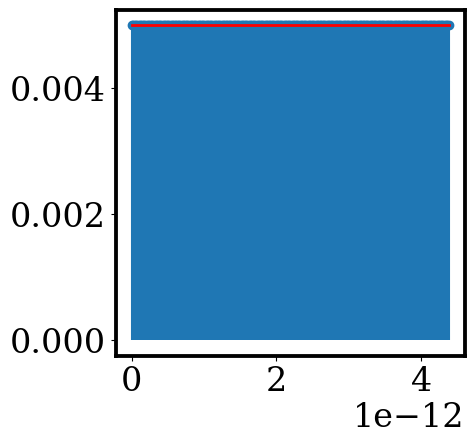

In [ ]:
Sq_charge = pulse_profile(tpulse,M)
Sq_mass = pulse_profile(tpulse,M)
t = np.linspace(0,tpulse,M)
plt.stem(t,Sq_charge, basefmt=" ", use_line_collection=True)
plt.plot(t,Sq_mass,'r',lw=2)

Sq_Params_sys = [Dt,fp*Sq_mass,fp*Sq_charge,V0,d]

In [ ]:
position_sq,velocity_sq,E_field_sq = Simulation(2,Sq_Params_sys,ini_conds,iterations)

<Figure size 450x500 with 0 Axes>

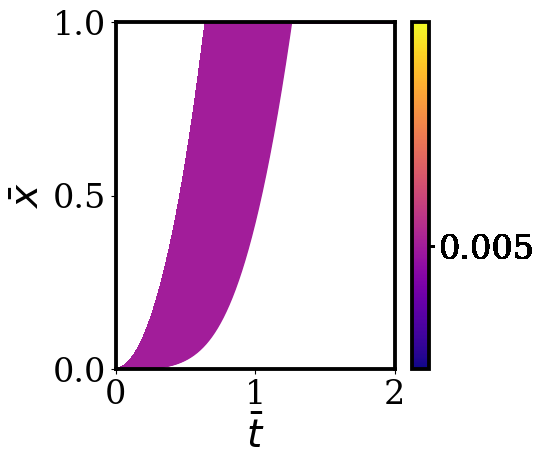

In [ ]:
color_sq = fp*Sq_charge
plt.figure(figsize=(4.5,5))
fig, ax = plt.subplots(dpi=100)
for i in range(M):
    ax.plot(time, position_sq[:,:i], lw=1.,c=cmap.to_rgba(color_sq[i]))
fig.colorbar(cmap, ticks=color_sq)

plt.xlim(0.,2)
plt.xlabel('$\\bar{t}$',fontsize=28)
plt.ylim(0,1)
plt.ylabel('$\\bar{x}$',fontsize=28)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)

# plt.text(1.5, 0.88, '(a)', fontsize=26)
# plt.savefig('position_sq.png',bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
Tcl

4.38052526525465e-11

In [ ]:
# for i in range(M):
#   print('sheet',i)
#   plt.plot(time, position_sq[:,i], lw=2,c=cmap.to_rgba(color_sq[i]))
#   plt.show()

### 1.2 Trapezoidal

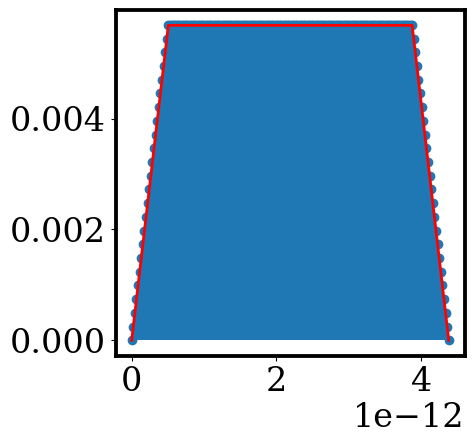

In [ ]:
Tr_charge = pulse_profile(tpulse,M,Type = 'trapezoidal')
Tr_mass = pulse_profile(tpulse,M,Type = 'trapezoidal')
t = np.linspace(0,tpulse,M)
plt.stem(t,Tr_charge, basefmt=" ", use_line_collection=True)
plt.plot(t,Tr_mass,'r',lw=2)

Tr_Params_sys = [Dt,fp*Tr_mass,fp*Tr_charge,V0,d]

In [ ]:
position_tr,velocity_tr,E_field_tr = Simulation(2,Tr_Params_sys,ini_conds,iterations)

<Figure size 450x500 with 0 Axes>

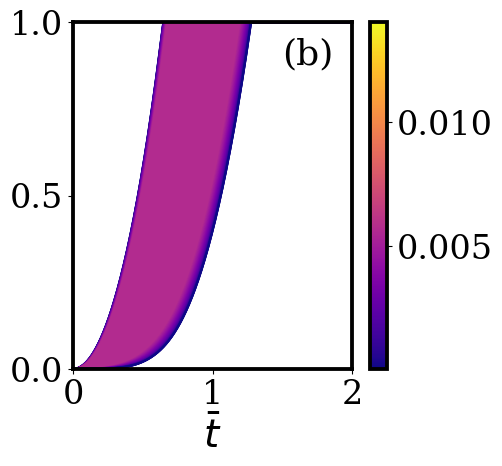

In [ ]:
color_tr = fp*Tr_charge
plt.figure(figsize=(4.5,5))
fig, ax = plt.subplots(dpi=100)
for i in range(M):
    ax.plot(time, position_tr[:,i], lw =1.5, c=cmap.to_rgba(color_tr[i]))
fig.colorbar(cmap)

plt.xlim(0,2)
plt.xlabel('$\\bar{t}$',fontsize=28)
plt.ylim(0,1)
# plt.ylabel('$\\bar{x}$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)

plt.text(1.5, 0.88, '(b)', fontsize=26)
plt.savefig('position_tr.png',bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# for i in range(M):
#   print('sheet',i)
#   plt.plot(time, position_tr[:,i], lw=2,c=cmap.to_rgba(color_sq[i]))
#   plt.show()

### 1.3 Gaussian

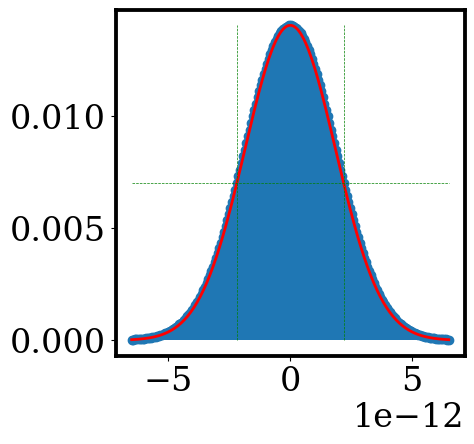

In [ ]:
Ga_charge = pulse_profile(tpulse,M,Type = 'gauss')
Ga_mass = pulse_profile(tpulse,M,Type = 'gauss')
sig2 = tpulse **2/np.log(256)
sig = np.sqrt(sig2)
t = np.linspace(-3.5*sig, 3.5*sig, M)
plt.stem(t,Ga_charge, basefmt=" ", use_line_collection=True)
plt.plot(t,Ga_mass,'r',lw=2)
plt.vlines(-tpulse/2, 0, max(Ga_mass), 'g','--',lw=0.5)
plt.vlines(tpulse/2, 0, max(Ga_mass), 'g','--',lw=0.5)
plt.hlines(max(Ga_mass)/2, -3.5*sig,3.5*sig, 'g','--',lw=0.5)

Ga_Params_sys = [Dt,fp*Ga_mass,fp*Ga_charge,V0,d]

In [ ]:
position_ga,velocity_ga,E_field_ga = Simulation(2,Ga_Params_sys,ini_conds,iterations)

<Figure size 450x500 with 0 Axes>

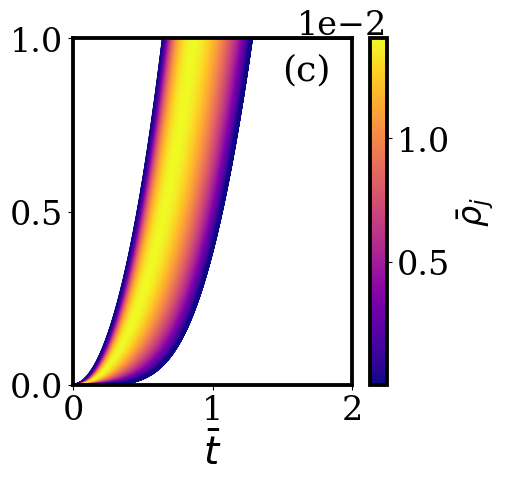

In [ ]:
color_ga = fp*Ga_charge
plt.figure(figsize=(4.5,5))
fig, ax = plt.subplots(dpi=100)
for i in range(M):
    ax.plot(time, position_ga[:,i],lw=2, c=cmap.to_rgba(color_ga[i]))
cbar = fig.colorbar(cmap,label='$\\bar{\\rho}_j$')
cbar.formatter.set_powerlimits((0, 0))
plt.xlim(0,2)
plt.xlabel('$\\bar{t}$',fontsize=28)
plt.ylim(0,1)
# plt.ylabel('$\\bar{x}$',fontsize=24)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)

plt.text(1.5, 0.88, '(c)', fontsize=26)
plt.savefig('position_ga.png',bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# for i in range(M):
#   print('sheet',i)
#   plt.plot(time, position_ga[:,i], lw=2,c=cmap.to_rgba(color_sq[i]))
#   plt.show()

## 2. Current density

### 2.1 Square-top

In [ ]:
Dt = 1/M
k = [0.1,0.25,.5,.75,1]
J_sq_l = []
for i in range(len(k)):
  Sq_Params_sys = [k[i]*Dt,fp*Sq_mass,fp*Sq_charge,V0,d]
  position_sq,velocity_sq,E_field_sq = Simulation(2,Sq_Params_sys,ini_conds,iterations)
  J_sq_l.append(Current_density(velocity_sq,Sq_charge))

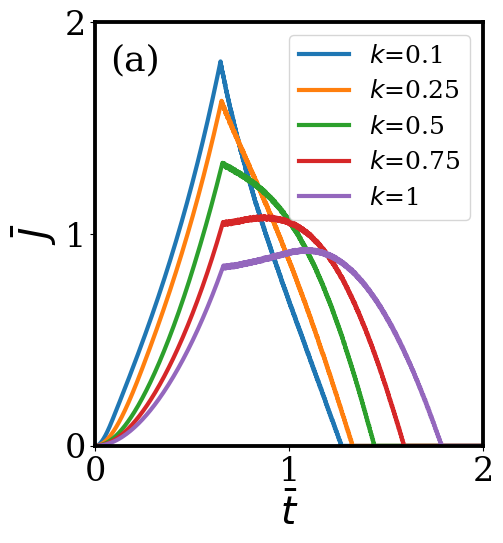

In [ ]:
plt.figure(figsize=(5,5.5))
plt.text(0.075, 1.775, '(a)', fontsize=26)
plt.locator_params(axis='y', nbins=3)
for i in range(len(k)):
  plt.plot(time,J_sq_l[i],lw=3,label=f"$k$={k[i]}")
  plt.xlim(0,2)
  plt.xlabel('$\\bar{t}$',fontsize=28)
  plt.ylim(0,2)
  plt.ylabel('$\\bar{J}$',fontsize=28)
  plt.legend(fontsize=18)
  plt.locator_params(axis='y', nbins=3)
  plt.locator_params(axis='x', nbins=3)

### 2.2 Trapezoidal

In [ ]:
Dt = 1/M
k = [0.1,0.25,.5,.75,1]
J_tr_l = []
for i in range(len(k)):
  Tr_Params_sys = [k[i]*Dt,fp*Tr_mass,fp*Tr_charge,V0,d]
  position_tr,velocity_tr,E_field_tr = Simulation(2,Tr_Params_sys,ini_conds,iterations)
  J_tr_l.append(Current_density(velocity_tr,Tr_charge))

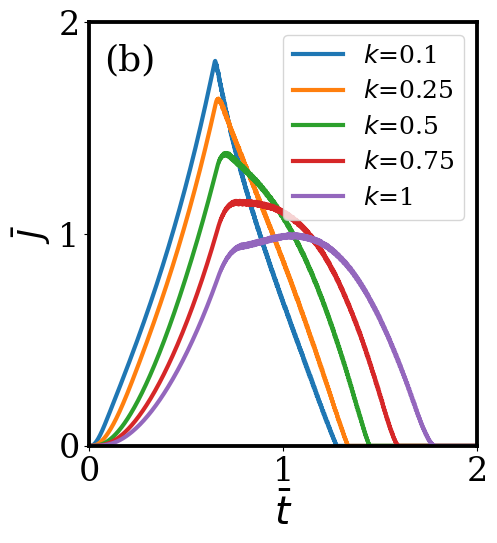

In [ ]:
plt.figure(figsize=(5,5.5))
plt.locator_params(axis='y', nbins=3)
plt.text(0.075, 1.775, '(b)', fontsize=26)

for i in range(len(k)):
  plt.plot(time,J_tr_l[i],lw=3,label=f"$k$={k[i]}")
  plt.xlim(0,2)
  plt.ylabel('$\\bar{J}$',fontsize=24)
  plt.ylim(0,2)
  plt.xlabel('$\\bar{t}$',fontsize=28)
  plt.legend(fontsize=18)
  plt.locator_params(axis='x', nbins=3)

### 2.3 Gaussian

In [ ]:
Dt = 1/M
k = [0.1,0.25,.5,.75,1]
J_ga_l = []
for i in range(len(k)):
  Ga_Params_sys = [k[i]*Dt,fp*Ga_mass,fp*Ga_charge,V0,d]
  position_ga,velocity_ga,E_field_ga = Simulation(2,Ga_Params_sys,ini_conds,iterations)
  J_ga_l.append(Current_density(velocity_ga,Ga_charge))

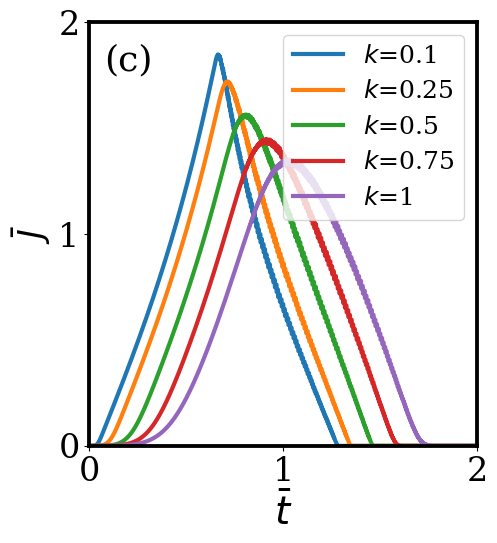

In [ ]:
plt.figure(figsize=(5,5.5))
plt.text(0.075, 1.775, '(c)', fontsize=26)
plt.locator_params(axis='y', nbins=3)
for i in range(len(k)):
  plt.plot(time,J_ga_l[i],lw=3,label=f"$k$={k[i]}")
  plt.xlim(0,2)
  plt.xlabel('$\\bar{t}$',fontsize=28)
  plt.ylim(0,2)
  plt.ylabel('$\\bar{J}$',fontsize=24)
  plt.locator_params(axis='y', nbins=3)
  plt.legend(fontsize=18)

## 3. Evolution Snapshots

In [ ]:
size = 18
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':2.75,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

In [ ]:
fp = 1
kp = .1
Dt = kp/M

In [ ]:
charge_mult = []
mass_mult = []
charge_mult.append(fp*Sq_charge)
charge_mult.append(fp*Tr_charge)
charge_mult.append(fp*Ga_charge)
mass_mult.append(fp*Sq_mass)
mass_mult.append(fp*Tr_mass)
mass_mult.append(fp*Ga_mass)

In [ ]:
position_mult = []
velocity_mult = []
E_field_mult = []
for i in range(3):
    Mass  = mass_mult[i]
    Charge = charge_mult[i]
    Params_sys = [Dt,Mass,Charge,V0,d]
    res_ = Simulation(2,Params_sys,ini_conds,iterations)
    position_mult.append(res_[0])
    velocity_mult.append(res_[1])
    E_field_mult.append(res_[2])

____

# PIC Results

In [ ]:
def read_text_files2(folder_path):
    # Initialize a dictionary to save the name and value of each DataFrame
    dict_df = {}

    # Iterate through all files and subdirectories in the given folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Check if the file starts with 'e' and has a .txt extension
            if file.startswith('u') and file.endswith('.txt'):
                # Construct the file path
                file_path = os.path.join(root, file)

                # Extract subfolder and subsubfolder names
                subfolder_name = os.path.basename(os.path.dirname(root))
                subsubfolder_name = os.path.basename(os.path.dirname(file_path))

                # Create a unique DataFrame name
                df_name = f"{subfolder_name}_{subsubfolder_name}_{os.path.splitext(file)[0]}"

                # Define custom column names
                column_names = ['p', 'u']

                # Read the text file into a DataFrame, skipping the first line and using custom column names
                df = pd.read_csv(file_path, delimiter='\t\t', skiprows=2, names=column_names)

                # Define the values to be dropped
                values_to_drop = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 46, 46.5, 47, 47.5, 48, 48.5, 49, 49.5, 50]

                # Drop rows where 'p' column matches the specified values
                df = df[~df['p'].isin(values_to_drop)]

                # Assign the DataFrame to the dynamically generated name
                globals()[df_name] = df

                # Save the DataFrame and its name to the dictionary
                dict_df[df_name] = df

                # Print information about the loaded DataFrame
                print(f"Loaded DataFrame '{df_name}' from '{file_path}'")

    # Return the dictionary containing DataFrame names and values
    return dict_df

In [ ]:
# Example usage:
folder_path = '/content/drive/MyDrive/Research/PIC/NewPIC/sim 05 17/phase_space'
dict_df = read_text_files2(folder_path)

Loaded DataFrame 'phase_space_trapezoidal_u01_1' from '/content/drive/MyDrive/Research/PIC/NewPIC/sim 05 17/phase_space/trapezoidal/u01_1.txt'
Loaded DataFrame 'phase_space_trapezoidal_u01_2' from '/content/drive/MyDrive/Research/PIC/NewPIC/sim 05 17/phase_space/trapezoidal/u01_2.txt'
Loaded DataFrame 'phase_space_trapezoidal_u01_3' from '/content/drive/MyDrive/Research/PIC/NewPIC/sim 05 17/phase_space/trapezoidal/u01_3.txt'
Loaded DataFrame 'phase_space_gaussian_u01_1' from '/content/drive/MyDrive/Research/PIC/NewPIC/sim 05 17/phase_space/gaussian/u01_1.txt'
Loaded DataFrame 'phase_space_gaussian_u01_2' from '/content/drive/MyDrive/Research/PIC/NewPIC/sim 05 17/phase_space/gaussian/u01_2.txt'
Loaded DataFrame 'phase_space_gaussian_u01_3' from '/content/drive/MyDrive/Research/PIC/NewPIC/sim 05 17/phase_space/gaussian/u01_3.txt'
Loaded DataFrame 'phase_space_square_top_u01_1' from '/content/drive/MyDrive/Research/PIC/NewPIC/sim 05 17/phase_space/square_top/u01_1.txt'
Loaded DataFrame 'p

In [ ]:
v = np.sqrt(2*V0*cst.e/cst.m_e)

In [ ]:
u1s = dict_df['phase_space_square_top_u01_1']
u1t = dict_df['phase_space_trapezoidal_u01_1']
u1g = dict_df['phase_space_gaussian_u01_1']
# print(u1)

(0.0, 1.0)

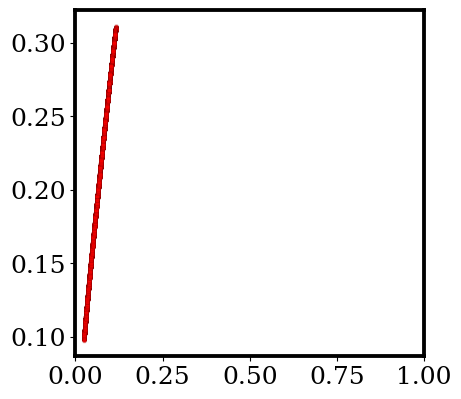

In [ ]:
snap1_vels = np.array(u1s['u']/v)
snap1_poss = np.array(u1s['p']/1.5e-3)
plt.scatter(snap1_poss[::3],snap1_vels[::3], s=10, linewidth=.1, facecolors='red', edgecolors='k',alpha=.1)
plt.xlim(0,1)

(0.0, 1.0)

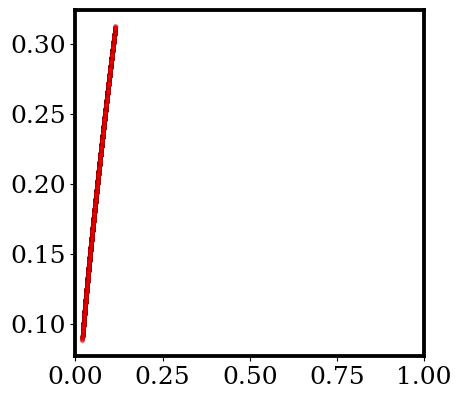

In [ ]:
snap1_velt = np.array(u1t['u']/v)
snap1_post = np.array(u1t['p']/1.5e-3)
plt.scatter(snap1_post[::3],snap1_velt[::3], s=10, linewidth=.1, facecolors='red', edgecolors='k',alpha=.1)
plt.xlim(0,1)

(0.0, 1.0)

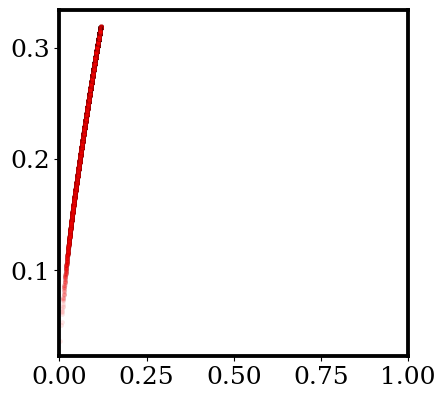

In [ ]:
snap1_velg = np.array(u1g['u']/v)
snap1_posg = np.array(u1g['p']/1.5e-3)
plt.scatter(snap1_posg[::3],snap1_velg[::3], s=10, linewidth=.1, facecolors='red', edgecolors='k',alpha=.1)
plt.xlim(0,1)

In [ ]:
u2s = dict_df['phase_space_square_top_u01_2']
u2t = dict_df['phase_space_trapezoidal_u01_2']
u2g = dict_df['phase_space_gaussian_u01_2']
# print(u2)

(0.0, 1.0)

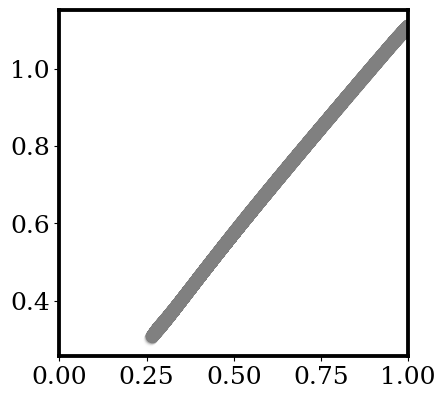

In [ ]:
snap2_vels = np.array(u2s['u']/v)
snap2_poss = np.array(u2s['p']/1.5e-3)
plt.scatter(snap2_poss,snap2_vels, s=100, linewidth=1, facecolors='gray', edgecolors='none',alpha=.005)
plt.xlim(0,1)

(0.0, 1.0)

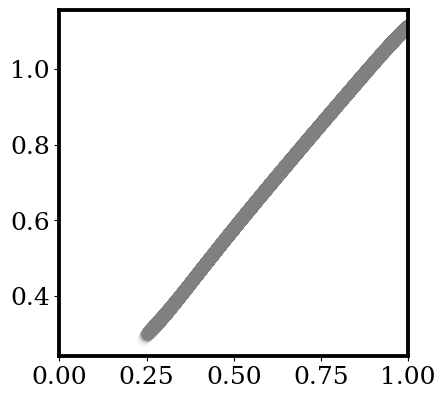

In [ ]:
snap2_velt = np.array(u2t['u']/v)
snap2_post = np.array(u2t['p']/1.5e-3)
plt.scatter(snap2_post,snap2_velt, s=100, linewidth=1, facecolors='gray', edgecolors='none',alpha=.005)
plt.xlim(0,1)

(0.0, 1.0)

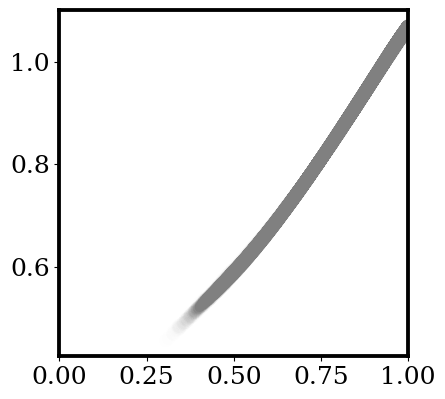

In [ ]:
snap2_velg = np.array(u2g['u']/v)
snap2_posg = np.array(u2g['p']/1.5e-3)
plt.scatter(snap2_posg,snap2_velg, s=100, linewidth=1, facecolors='gray', edgecolors='none',alpha=.005)
plt.xlim(0,1)

In [ ]:
u3s = dict_df['phase_space_square_top_u01_3']
u3t = dict_df['phase_space_trapezoidal_u01_3']
u3g = dict_df['phase_space_gaussian_u01_3']
# print(u2)

(0.0, 1.0)

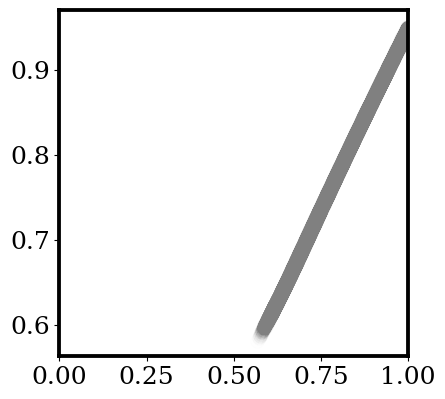

In [ ]:
snap3_vels = np.array(u3s['u']/v)
snap3_poss = np.array(u3s['p']/1.5e-3)
plt.scatter(snap3_poss,snap3_vels, s=100, linewidth=1, facecolors='gray', edgecolors='gray',alpha=.005)
plt.xlim(0,1)

(0.0, 1.0)

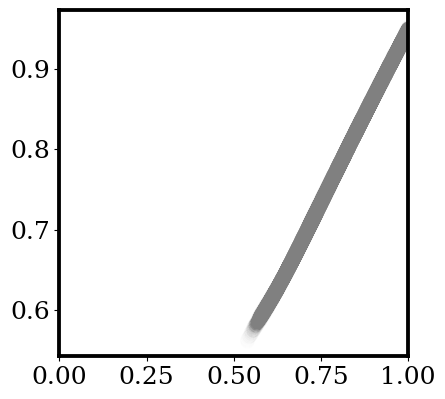

In [ ]:
snap3_velt = np.array(u3t['u']/v)
snap3_post = np.array(u3t['p']/1.5e-3)
plt.scatter(snap3_post,snap3_velt, s=100, linewidth=1, facecolors='gray', edgecolors='gray',alpha=.005)
plt.xlim(0,1)

(0.0, 1.0)

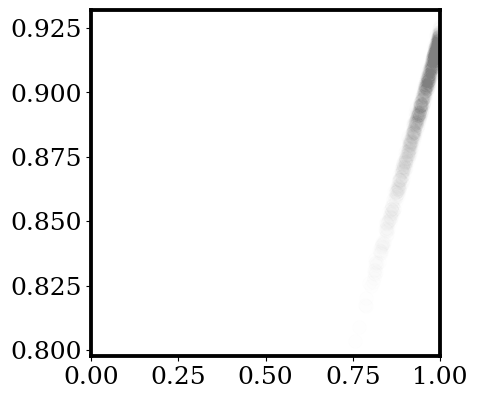

In [ ]:
snap3_velg = np.array(u3g['u']/v)
snap3_posg = np.array(u3g['p']/1.5e-3)
plt.scatter(snap3_posg,snap3_velg, s=100, linewidth=1, facecolors='gray', edgecolors='gray',alpha=.005)
plt.xlim(0,1)

In [ ]:
PIC_phase_poss = [snap1_poss,snap2_poss,snap3_poss]
PIC_phase_vels = [snap1_vels,snap2_vels,snap3_vels]

PIC_phase_post = [snap1_post,snap2_post,snap3_post]
PIC_phase_velt = [snap1_velt,snap2_velt,snap3_velt]

PIC_phase_posg = [snap1_posg,snap2_posg,snap3_posg]
PIC_phase_velg = [snap1_velg,snap2_velg,snap3_velg]

In [ ]:
def plots_shape_phase_mult(position, velocity, E_field, rho, n=2):
    prof = ['Square', 'Trapezoidal', 'Gaussian']
    lag = [230,660,887]
    len_rho = len(rho)
    for i in range(1, n+2):
        if i == n:
            lag = lag
        fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))
        l = 2*(i-1)
        for j in range(len_rho):
            shape = np.array([position[j][lag[i-1]], rho[j]])
            phase = np.array([position[j][lag[i-1]], velocity[j][lag[i-1]]])
            axs[0].plot(shape[0], shape[1], lw=4, label=f"{prof[j]}")
            axs[0].set_ylabel("$\\bar{\\rho_j}$")
            axs[0].set_xlim(0, 1)
            axs[0].set_ylim(0, .015)
            axs[0].locator_params(nbins=3)
            if i == 1:
                axs[0].legend(fontsize=16)
            if j == 0:
                axs[0].annotate(f'({chr(97 + l)})', xy=(1, 0), xycoords='axes fraction', fontsize=20,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')
            axs[1].scatter(PIC_phase_poss[i-1][::100],PIC_phase_vels[i-1][::100],marker='o',s=50,linewidth=1,facecolors='royalblue',edgecolors='royalblue',alpha=1,label='PIC Square-top')
            axs[1].scatter(PIC_phase_post[i-1][::100],PIC_phase_velt[i-1][::100],marker='o',s=30,linewidth=1,facecolors='orange',edgecolors='orange',alpha=1,label='PIC Trapezoidal')
            axs[1].scatter(PIC_phase_posg[i-1][::100],PIC_phase_velg[i-1][::100],marker='o',s=40,linewidth=1,facecolors='forestgreen',edgecolors='forestgreen',alpha=1,label='PIC Gaussian')
            axs[1].plot(phase[0], phase[1], lw=4)
            axs[1].set_ylabel("$\\bar{v}$")
            axs[1].set_xlim(0, 1)
            axs[1].locator_params(nbins=3)
            if i == 1:
              if j == 0:
                axs[1].legend(fontsize=16)
            if  j == 0:
                axs[1].annotate(f'({chr(97 + l+1)})', xy=(1, 0), xycoords='axes fraction', fontsize=20,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')
            if i == n+1:
                axs[0].set_xlabel("$\\bar{x}$")
                axs[1].set_xlabel("$\\bar{x}$")
        axs[1].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
        axs[0].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
        fig.tight_layout(pad=.01)
        plt.savefig(f'snapshots_ga2{i}.png', dpi=300)
        plt.show()

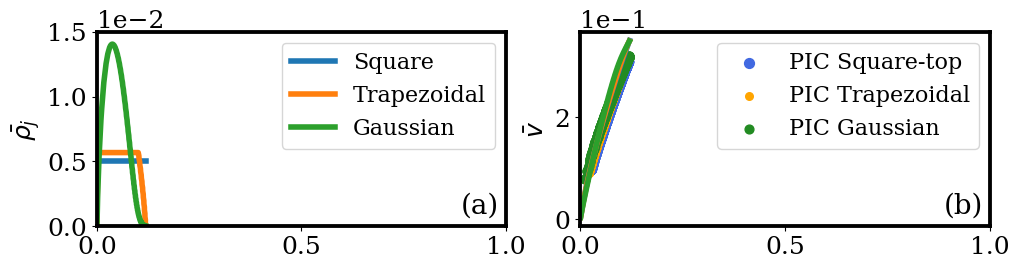

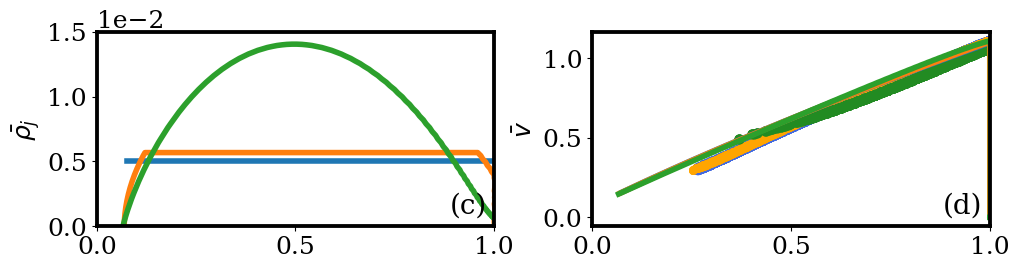

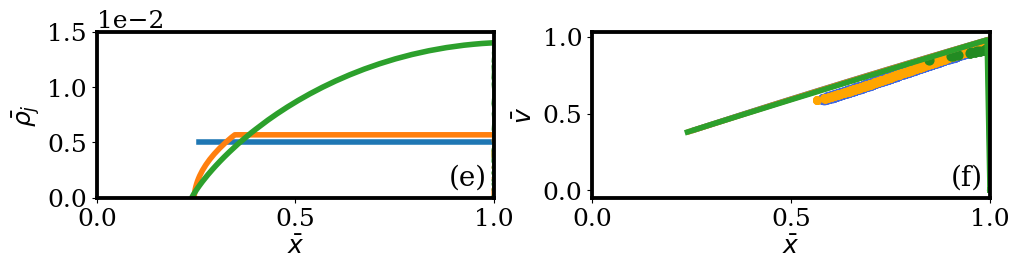

In [ ]:
plots_shape_phase_mult(position_mult,velocity_mult,E_field_mult,charge_mult)

In [ ]:
def plots_shape_phase_mult2(position, velocity, E_field, rho, n=2):
    prof = ['Square', 'Trapezoidal', 'Gaussian']
    lag = [230,660,887]

    len_rho = len(rho)

    for i in range(1, n+2):
        if i == n:
            lag = lag

        fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))

        l = 2*(i-1)

        for j in range(len_rho):
            shape = np.array([position[j][lag[i-1]], rho[j]])
            phase = np.array([position[j][lag[i-1]], velocity[j][lag[i-1]]])

            axs[0].plot(shape[0], shape[1], lw=4, label=f"$f$ = {f[j]}")
            axs[0].set_ylabel("$\\bar{\\rho_j}$")
            axs[0].set_xlim(0, 1)
            axs[0].set_ylim(0, .015)
            axs[0].locator_params(nbins=3)

            if i == 1:
                axs[0].legend(fontsize=15.5)
            if j == 0:
                axs[0].annotate(f'({chr(97 + l)})', xy=(1, 0), xycoords='axes fraction', fontsize=20,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')

            axs[1].plot(phase[0], phase[1], lw=4)
            axs[1].set_ylabel("$\\bar{v}$")
            axs[1].set_xlim(0, 1)
            axs[1].locator_params(nbins=3)

            if  j == 0:
                axs[1].annotate(f'({chr(97 + l+1)})', xy=(1, 0), xycoords='axes fraction', fontsize=20,
              xytext=(-5, 5), textcoords='offset points',
              ha='right', va='bottom')

            if i == n+1:
                axs[0].set_xlabel("$\\bar{x}$")
                axs[1].set_xlabel("$\\bar{x}$")

        axs[1].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
        axs[0].ticklabel_format(style='sci', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)

        fig.tight_layout(pad=.01)
        plt.savefig(f'snapshots_ga2{i}.png', dpi=300)
        plt.show()

Text(0, 0.5, '$\\rho$')

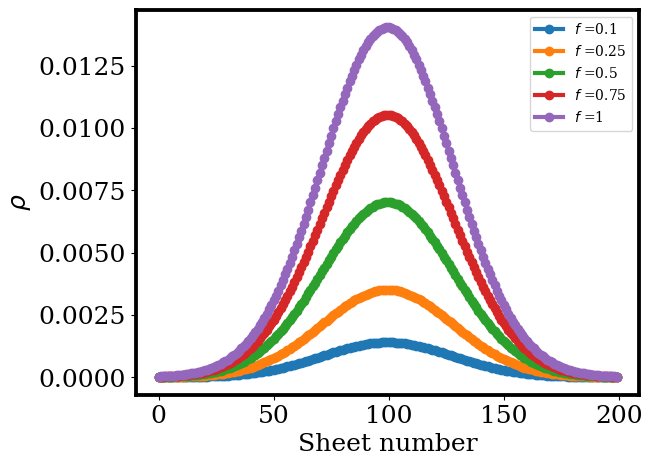

In [ ]:
Ga_charge_mult2 = []
Ga_mass_mult2 = []
f = [0.1,0.25,.5,.75,1]

for i in range(5):
    Ga_charge_mult2.append(f[i]*pulse_profile(tpulse,M,'gauss'))
    Ga_mass_mult2.append(f[i]*pulse_profile(tpulse,M,'gauss'))

Ga_mass_mult2 = np.array(Ga_mass_mult2)
Ga_charge_mult2 = np.array(Ga_charge_mult2)

plt.figure(figsize=(6.5, 5))
for i in range(5):
    plt.plot(Ga_charge_mult2[i],'o-',lw=3,label=f"$f$ ={f[i]}")
    plt.legend(fontsize="10")

plt.xlabel('Sheet number')
plt.ylabel('$\\rho$')

In [ ]:
position_g_mult2 = []
velocity_g_mult2 = []
E_field_g_mult2 = []

fp = 1
kp = .1
Dt = kp/M

for i in range(5):

    Ga_charge2 = Ga_charge_mult2[i]
    Ga_mass2 = Ga_mass_mult2[i]

    Ga_Params_sys2 = [Dt,Ga_mass2,Ga_charge2,V0,d]

    res_2 = Simulation(2,Ga_Params_sys2,ini_conds,iterations)

    position_g_mult2.append(res_2[0])
    velocity_g_mult2.append(res_2[1])
    E_field_g_mult2.append(res_2[2])

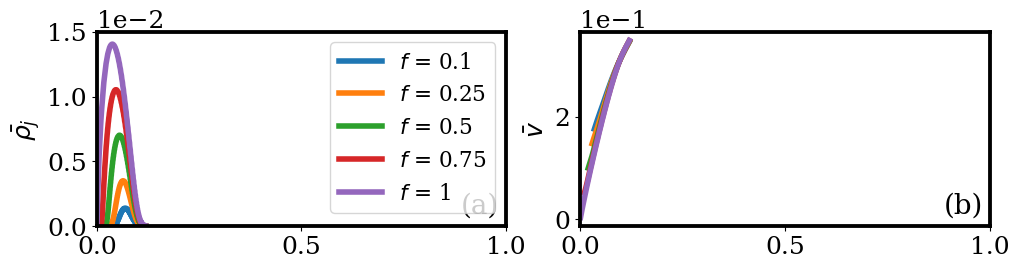

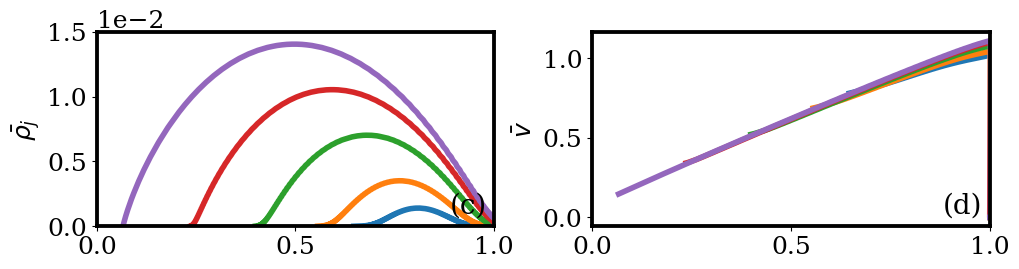

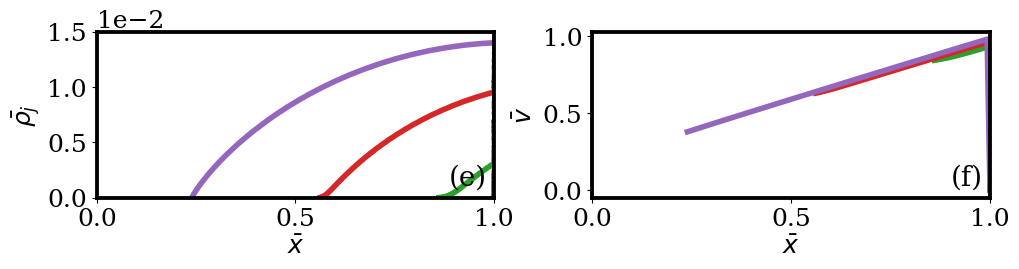

In [ ]:
plots_shape_phase_mult2(position_g_mult2,velocity_g_mult2,E_field_g_mult2,Ga_charge_mult2)

### 1.5 Distorsion of the pulse

In [ ]:
def th_distor(f,k):
  dist = ((3/4)*f**1)/k
  return dist

#### Distorsion with pulse length

The pulse charge is maintained at 100%

In [ ]:
meanS = np.array([4.45454545, 2.35454545, 1.48181818, 1.22121212, 1.11818182])
meanT = np.array([4.63636364, 2.5       , 1.61363636, 1.34545455, 1.24545455])
meanG = np.array([3.36363636, 2.16363636, 1.90454545, 1.86060606, 1.76136364])

errorS = np.array([0.        , 0.        , 0.        , 0.00675721, 0.        ])
errorT = np.array([0.        , 0.        , 0.        , 0.00844652, 0.        ])
errorG = np.array([6.96373765e-16, 0., 0., 0., 0])

In [ ]:
len(time)

2000

In [ ]:
k_range = [.1,.25,.5,.75,1]  #np.linspace(0.1,1,5)  # Pulse length range

In [ ]:
distorsion_list_ga_k = []
distorsion_list_tr_k = []
distorsion_list_sq_k = []
# figure(figsize=(9, 4))

Dt = 1/M

distorsion_list_gauss_k = []
for k in k_range:
    Sq_Params_sys = [k*Dt,Sq_mass,Sq_charge,V0,d]
    Tr_Params_sys = [k*Dt,Tr_mass,Tr_charge,V0,d]
    Ga_Params_sys = [k*Dt,Ga_mass,Ga_charge,V0,d]

    position_sq,velocity_sq,E_field_sq = Simulation(2,Sq_Params_sys,ini_conds,iterations)
    position_tr,velocity_tr,E_field_tr = Simulation(2,Tr_Params_sys,ini_conds,iterations)
    position_ga,velocity_ga,E_field_ga = Simulation(2,Ga_Params_sys,ini_conds,iterations)

    distorsion_list_sq_k.append(distorsion(position_sq,time,k*Dt,M))
    distorsion_list_ga_k.append(distorsion(position_ga,time,k*Dt,M))
    distorsion_list_tr_k.append(distorsion(position_tr,time,k*Dt,M))

distorsion_list_sq_k = np.array(distorsion_list_sq_k)
distorsion_list_tr_k = np.array(distorsion_list_tr_k)
distorsion_list_ga_k = np.array(distorsion_list_ga_k)

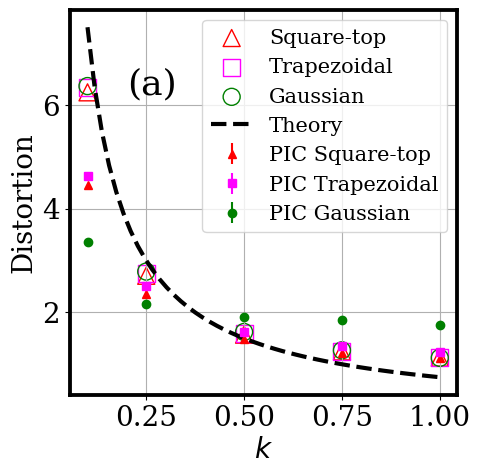

In [ ]:
th = th_distor(1,np.linspace(0.1,1))

plt.figure(figsize=(5, 5))
plt.scatter(k_range,distorsion_list_sq_k,marker='^',s=150,edgecolors='r',facecolors='none',label='Square-top')
plt.scatter(k_range,distorsion_list_tr_k,marker='s',s=150,edgecolors='magenta',facecolors='none',label='Trapezoidal')
plt.scatter(k_range,distorsion_list_ga_k,marker='o',s=150,edgecolors='g',facecolors='none',label='Gaussian')
# plt.scatter(k_range,XOOPIC,marker='x',s=150,label='XOOPIC')
plt.plot(np.linspace(0.1,1),th,'--',color='black',markerfacecolor='None',lw=3,label='Theory')

#__________________________________________________________________________________
plt.errorbar(k_range, meanS, yerr=errorS, fmt='^',color='r',label='PIC Square-top')
# plt.scatter(k_range, meanS,  marker='^', s = 100,color='r')
plt.errorbar(k_range, meanT, yerr=errorT, fmt='s',color='magenta',label='PIC Trapezoidal')
plt.errorbar(k_range, meanG, yerr=errorG, fmt='o',color='g',label='PIC Gaussian')
#___________________________________________________________________________________________


plt.text(0.2, 6.2, '(a)', fontsize=26)
plt.ylabel('Distortion')
plt.xlabel('$k$')
# plt.yscale('log')
plt.legend(fontsize=15.)
# plt.xlim(0.05,1.05)
# plt.ylim(0,7.)
plt.locator_params(axis='x',nbins=4)
plt.locator_params(axis='y',nbins=4)
plt.grid()
# plt.yscale('log')
# plt.xscale('log')
plt.savefig('Dist_with_k.png', bbox_inches='tight', dpi=300)
  # plt.grid()

#### Distorsion with charge

The pulse length is maintained at 10%

In [ ]:
meanS = np.array([1.25      , 1.61363636, 2.31818182, 3.18181818, 4.45454545])
meanT = np.array([1.34090909, 1.75      , 2.45454545, 3.36363636, 4.63636364])
meanG = np.array([1.84090909, 2.04545455, 2.59090909, 2.90909091, 3.36363636])

errorS = np.array([0., 0., 0., 0., 0.])
errorT = np.array([0.06465517, 0.        , 0.        , 0.        , 0.        ])
errorG = np.array([0., 0., 0., 0., 0.])

In [ ]:
f_range = [.1,.25,.5,.75,1]  #np.linspace(0.1,1,5)  # Pulse charge range

distorsion_list_ga_f = []
distorsion_list_tr_f = []
distorsion_list_sq_f = []
# figure(figsize=(9, 4))

Dt = 1/M

distorsion_list_gauss_f = []
for f in f_range:

    Sq_Params_sys = [0.1*Dt,f*Sq_mass,f*Sq_charge,V0,d]
    Tr_Params_sys = [0.1*Dt,f*Tr_mass,f*Tr_charge,V0,d]
    Ga_Params_sys = [0.1*Dt,f*Ga_mass,f*Ga_charge,V0,d]

    position_sq,velocity_sq,E_field_sq = Simulation(2,Sq_Params_sys,ini_conds,iterations)
    position_tr,velocity_tr,E_field_tr = Simulation(2,Tr_Params_sys,ini_conds,iterations)
    position_ga,velocity_ga,E_field_ga = Simulation(2,Ga_Params_sys,ini_conds,iterations)

    distorsion_list_sq_f.append(distorsion(position_sq,time,.1*Dt,M))
    distorsion_list_ga_f.append(distorsion(position_ga,time,.1*Dt,M))
    distorsion_list_tr_f.append(distorsion(position_tr,time,.1*Dt,M))

distorsion_list_sq_f = np.array(distorsion_list_sq_f)
distorsion_list_tr_f = np.array(distorsion_list_tr_f)
distorsion_list_ga_f = np.array(distorsion_list_ga_f)

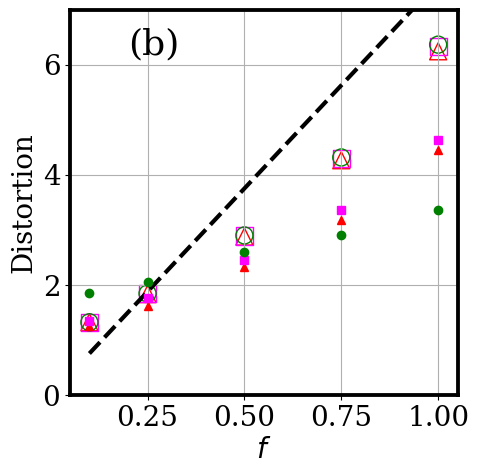

In [ ]:
th = th_distor(np.linspace(0.1,1),0.1)

# plt.plot(k_range,distorsion_list_ga_k,'black',marker = 'D',markerfacecolor='None',lw=1.5,label='Theory')
plt.figure(figsize=(5, 5))
plt.scatter(f_range,distorsion_list_sq_f,marker='^',s=150,edgecolors='r',facecolors='none',label='Square-top')
plt.scatter(f_range,distorsion_list_tr_f,marker='s',s=150,edgecolors='magenta',facecolors='none',label='Trapezoidal')
plt.scatter(f_range,distorsion_list_ga_f,marker='o',s=150,edgecolors='g',facecolors='none',label='Gaussian')
# plt.scatter(f_range,XOOPIC,marker='x',s=150,label='XOOPIC')
plt.plot(np.linspace(0.1,1),th,'--',color='black',markerfacecolor='None',lw=3,label='Theory')

#__________________________________________________________________________________
plt.errorbar(k_range, meanS, yerr=errorS, fmt='^',color='r',label='PIC Square-top')
# plt.scatter(k_range, meanS,  marker='^', s = 100,color='r')
plt.errorbar(k_range, meanT, yerr=errorT, fmt='s',color='magenta',label='PIC Trapezoidal')
plt.errorbar(k_range, meanG, yerr=errorG, fmt='o',color='g',label='PIC Gaussian')
#___________________________________________________________________________________________

plt.text(0.2, 6.2, '(b)', fontsize=26)
plt.ylabel('Distortion')
plt.xlabel('$f$')
# plt.yscale('log')
plt.xlim(0.05,1.05)
plt.ylim(0,7)
plt.locator_params(axis='x',nbins=4)
plt.locator_params(axis='y',nbins=4)
# plt.legend(fontsize=15)
plt.savefig('Dist_with_f.png', bbox_inches='tight', dpi=300)
plt.grid()
# plt.ylim(0,2)

#### Distorsion with charge and pulse length

In [ ]:
f_range = np.linspace(0.1,1,15)  # Pulse charge range
k_range = np.linspace(0.1,1,15)   # Pulse length range
Distorsion_matrix_sq = np.zeros([len(f_range),len(k_range)])
Distorsion_matrix_tr = np.zeros([len(f_range),len(k_range)])
Distorsion_matrix_ga = np.zeros([len(f_range),len(k_range)])

Dt = 1/M

for i in range(len(f_range)):
    f = f_range[i]
    for j in range(len(k_range)):
        k = k_range[j]
        Sq_Params_sys = [k*Dt,f*Sq_mass,f*Sq_charge,V0,d]
        Tr_Params_sys = [k*Dt,f*Tr_mass,f*Tr_charge,V0,d]
        Ga_Params_sys = [k*Dt,f*Ga_mass,f*Ga_charge,V0,d]

        position_sq,velocity_sq,E_field_sq = Simulation(2,Sq_Params_sys,ini_conds,iterations)
        position_tr,velocity_tr,E_field_tr = Simulation(2,Tr_Params_sys,ini_conds,iterations)
        position_ga,velocity_ga,E_field_ga = Simulation(2,Ga_Params_sys,ini_conds,iterations)

        Distorsion_matrix_sq[i,j] = (distorsion(position_sq,time,k*Dt,M))
        Distorsion_matrix_tr[i,j] = (distorsion(position_tr,time,k*Dt,M))
        Distorsion_matrix_ga[i,j] = (distorsion(position_ga,time,k*Dt,M))

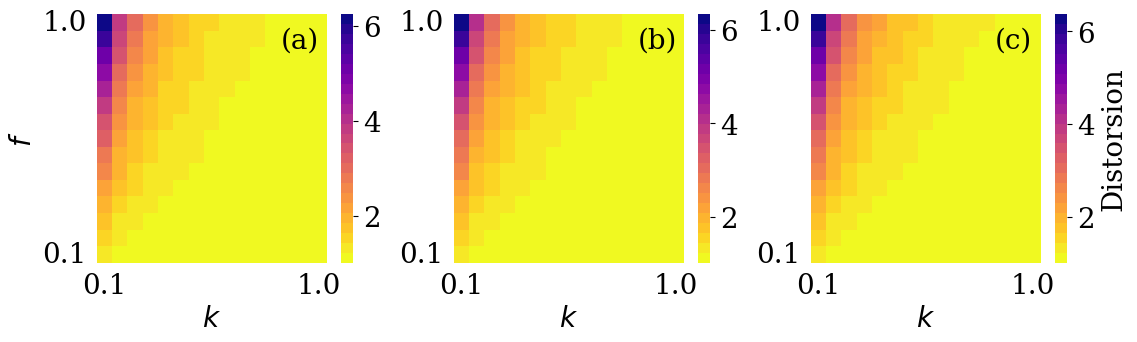

In [ ]:
new_cm = cm.get_cmap('plasma_r',25)
Distorsion_matrix_sq = np.flipud(Distorsion_matrix_sq)
Distorsion_matrix_tr = np.flipud(Distorsion_matrix_tr)
Distorsion_matrix_ga = np.flipud(Distorsion_matrix_ga)

f_range = np.flip(f_range)

plt.figure(figsize=(11.5, 3.5))

plt.subplot(131)
plt.text(12, 2, '(a)', fontsize=20)

heat_map = sns.heatmap(Distorsion_matrix_sq,xticklabels=k_range, yticklabels=f_range,cmap=new_cm,cbar=True)
heat_map.tick_params(left=False, bottom=False)

for index, label in enumerate(heat_map.get_xticklabels()):
  if index % len(k_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

for index, label in enumerate(heat_map.get_yticklabels()):
  if index % len(f_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

plt.xticks(rotation=0)
# plt.title("Distorsion")
plt.xlabel('$k$')
plt.ylabel('$f$')


plt.subplot(132)
plt.text(12, 2, '(b)', fontsize=20)
heat_map = sns.heatmap(Distorsion_matrix_tr,xticklabels=k_range, yticklabels=f_range,cmap=new_cm,cbar=True)
heat_map.tick_params(left=False, bottom=False)

for index, label in enumerate(heat_map.get_xticklabels()):
  if index % len(k_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

for index, label in enumerate(heat_map.get_yticklabels()):
  if index % len(f_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

plt.xticks(rotation=0)
# plt.title("Distorsion")
plt.xlabel('$k$')
# plt.ylabel('$\\rho/\\rho_{SCL}$')

plt.subplot(133)
plt.text(12, 2, '(c)', fontsize=20)
heat_map = sns.heatmap(Distorsion_matrix_ga,xticklabels=k_range, yticklabels=f_range,cmap=new_cm,cbar_kws={'label': 'Distorsion'})
heat_map.tick_params(left=False, bottom=False)

for index, label in enumerate(heat_map.get_xticklabels()):
  if index % len(k_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

for index, label in enumerate(heat_map.get_yticklabels()):
  if index % len(f_range) == 0 or index == len(f_range)-1 :
    label.set_visible(True)
  else:
    label.set_visible(False)

plt.xticks(rotation=0)
# plt.title("Distorsion")
plt.xlabel('$k$')
# plt.ylabel('$\\rho/\\rho_{SCL}$')

plt.tight_layout(pad=.5)

# plt.savefig('Dist_with_rho_tau.png', bbox_inches='tight', dpi=300)

## 1.7 Current limits

In [ ]:
Tau_val = np.linspace(0.1,1)
Jcrit_s = Norm_J_crit_s(Tau_val)
Jcrit_e = Norm_J_crit_e(Tau_val)

### Square-top

In [ ]:
Voltage = [V0]
distance = [d]

k_range = [0.1,0.25,0.5,0.75,1]  # Pulse length range

for s in range(len(Voltage)):

    print(f"Simulation {s+1}/{len(Voltage)}")
    print(" ")

    f_limit_sq = []

    Vg = Voltage[s]
    dist = distance[s]

    for i in range(len(k_range)):

        k = k_range[i]

        #=========================
        f=1
        Params_sys = [k*Dt,f*Sq_mass,f*Sq_charge,Vg,dist]
        while not limit_charge(2,Params_sys,ini_conds,iterations):
            Params_sys = [k*Dt,f*Sq_mass,f*Sq_charge,Vg,dist]
            f +=0.005
        print(f)

        print(f"*** {100*(i+1)/len(k_range)} % ***")

        f_limit_sq.append(f)
    f_limit_sq =np.array(f_limit_sq)

    print(" ")

Simulation 1/1
 
1.0199999999999996
*** 20.0 % ***
1.049999999999999
*** 40.0 % ***
1.1799999999999962
*** 60.0 % ***
1.4449999999999905
*** 80.0 % ***
1.7399999999999842
*** 100.0 % ***
 


In [ ]:
Jc_sq = (3/4)*f_limit_sq/k_range
Jc_sq

array([7.65 , 3.15 , 1.77 , 1.445, 1.305])

In [ ]:
# Jc_sq = np.array([7.65 , 3.12 , 1.635, 1.18 , 1.005])

### Trapezoid

In [ ]:
Voltage = [V0]
distance = [d]

k_range = [0.1,0.25,0.5,0.75,1]  # Pulse length range

for s in range(len(Voltage)):

    print(f"Simulation {s+1}/{len(Voltage)}")
    print(" ")

    f_limit_tr = []

    Vg = Voltage[s]
    dist = distance[s]

    for i in range(len(k_range)):

        k = k_range[i]

        #=========================
        f=1
        Params_sys = [k*Dt,f*Tr_mass,f*Tr_charge,Vg,dist]
        while not limit_charge(2,Params_sys,ini_conds,iterations):
            Params_sys = [k*Dt,f*Tr_mass,f*Tr_charge,Vg,dist]
            f +=0.005
        print(f)

        print(f"*** {100*(i+1)/len(k_range)} % ***")

        f_limit_tr.append(f)
    f_limit_tr =np.array(f_limit_tr)

    print(" ")

Simulation 1/1
 
1.0149999999999997
*** 20.0 % ***
1.0399999999999991
*** 40.0 % ***
1.1499999999999968
*** 60.0 % ***
1.3599999999999923
*** 80.0 % ***
1.6249999999999867
*** 100.0 % ***
 


In [ ]:
Jc_tr = (3/4)*f_limit_tr/k_range
Jc_tr

array([7.6125 , 3.12   , 1.725  , 1.36   , 1.21875])

### Gaussian

In [ ]:
Voltage = [V0]
distance = [d]

k_range = k_range = [0.1,0.25,0.5,0.75,1]  # Pulse length range

for s in range(len(Voltage)):

    print(f"Simulation {s+1}/{len(Voltage)}")
    print(" ")

    f_limit_ga = []

    Vg = Voltage[s]
    dist = distance[s]

    for i in range(len(k_range)):

        k = k_range[i]

        #=========================
        f=1
        Params_sys = [k*Dt,f*Ga_mass,f*Ga_charge,Vg,dist]
        while not limit_charge(2,Params_sys,ini_conds,iterations):
            Params_sys = [k*Dt,f*Ga_mass,f*Ga_charge,Vg,dist]
            f +=0.005
        print(f)

        print(f"*** {100*(i+1)/len(k_range)} % ***")

        f_limit_ga.append(f)
    f_limit_ga =np.array(f_limit_ga)

    print(" ")

Simulation 1/1
 
1.0099999999999998
*** 20.0 % ***
1.0299999999999994
*** 40.0 % ***
1.0749999999999984
*** 60.0 % ***
1.139999999999997
*** 80.0 % ***
1.2249999999999952
*** 100.0 % ***
 


In [ ]:
Jc_ga = (3/4)*f_limit_ga/k_range
Jc_ga

array([7.575  , 3.09   , 1.6125 , 1.14   , 0.91875])

In [ ]:
k01s = np.array([5.71e7,6.1431e7])
k025s = np.array([2.3346e7,2.5014e7])
k05s = np.array([1.2068e7,1.29e7])
k075s = np.array([8.05e6,9.12e6])
k1s = np.array([6.92e6,7.73e6])

PIC_sq = np.array([np.mean(k01s),np.mean(k025s),np.mean(k05s),np.mean(k075s),np.mean(k1s)])

XOOPIC_square = (3/4)* PIC_sq / 5389961.637

errors = np.zeros(5)

errors[0] = np.std(k01s*(3/4)/ 5389961.637)
errors[1] = np.std(k025s*(3/4) / 5389961.637)
errors[2] = np.std(k05s*(3/4) / 5389961.637)
errors[3] = np.std(k075s*(3/4) / 5389961.637)
errors[4] = np.std(k1s*(3/4) / 5389961.637)

# errors = errors / 5389961.637

In [ ]:
XOOPIC_square

array([8.2466496 , 3.36458795, 1.73711812, 1.19458179, 1.01925586])

In [ ]:
k01t = np.array([5.1683e7,5.5659e7])
k025t = np.array([2.2527e7,2.4134e7])
k05t = np.array([1.1264e7,1.2873e7])
k075t = np.array([8.5818e6,9.6545e6])
k1t = np.array([7.2409e6,8.0453e6])

PIC_tr = np.array([np.mean(k01t),np.mean(k025t),np.mean(k05t),np.mean(k075t),np.mean(k1t)])
XOOPIC_tr = (3/4)* PIC_tr / 5389961.637

errort = np.zeros(5)

errort[0] = np.std(k01t*(3/4)/ 5389961.637)
errort[1] = np.std(k025t*(3/4)/ 5389961.637)
errort[2] = np.std(k05t*(3/4)/ 5389961.637)
errort[3] = np.std(k075t*(3/4)/ 5389961.637)
errort[4] = np.std(k1t*(3/4)/ 5389961.637)

In [ ]:
k01g = np.array([4.8086e7,5.2327e7])
k025g = np.array([2.1410e7,2.1867e7])
k05g = np.array([1.2901e7,1.3225e7])
k075g = np.array([1.085e7,9.4604e6])
k1g = np.array([8.1338e6,9.0211e6])

PIC_g = np.array([np.mean(k01g),np.mean(k025g),np.mean(k05g),np.mean(k075g),np.mean(k1g)])
XOOPIC_g = (3/4)*PIC_g / 5389961.637

errorg = np.zeros(5)

errorg[0] = np.std(k01g*(3/4)/ 5389961.637)
errorg[1] = np.std(k025g*(3/4)/ 5389961.637)
errorg[2] = np.std(k05g*(3/4)/ 5389961.637)
errorg[3] = np.std(k075g*(3/4)/ 5389961.637)
errorg[4] = np.std(k1g*(3/4)/ 5389961.637)

In [ ]:
k_range = [0.1,0.25,0.5,0.75,1]  # Pulse length range
Jc_sq = np.array([7.65 , 3.15 , 1.77 , 1.445, 1.305])
Jc_tr = np.array([7.6125 , 3.12   , 1.725  , 1.36   , 1.21875])
Jc_ga = np.array([7.575  , 3.09   , 1.6125 , 1.14   , 0.91875])

In [ ]:
size = 18
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':2.75,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

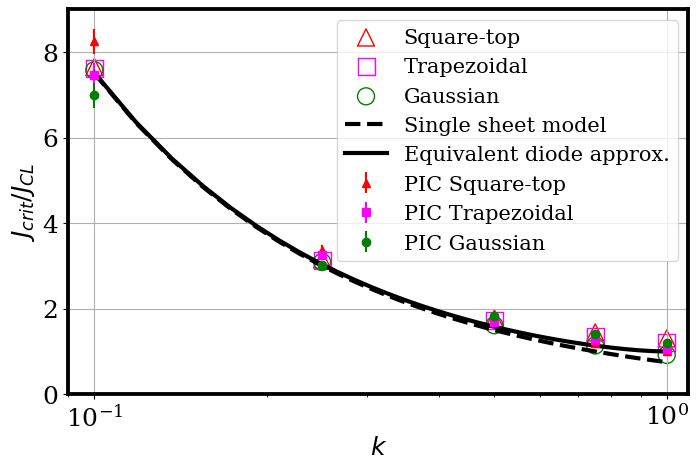

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(k_range,Jc_sq,marker='^',s=150,edgecolors='r',facecolors='none',label='Square-top')
plt.scatter(k_range,Jc_tr,marker='s',s=150,edgecolors='magenta',facecolors='none',label='Trapezoidal')
plt.scatter(k_range,Jc_ga,marker='o',s=150,edgecolors='g',facecolors='none',label='Gaussian')
# ================================================================
# plt.scatter(k_range,XOOPIC_square,marker='x',s=100,label='XOOPIC')
plt.errorbar(k_range, XOOPIC_square, yerr=errors, fmt='^',color='r',label='PIC Square-top')
plt.errorbar(k_range, XOOPIC_tr, yerr=errort, fmt='s',color='magenta',label='PIC Trapezoidal')
plt.errorbar(k_range, XOOPIC_g, yerr=errorg, fmt='o',color='g',label='PIC Gaussian')
# ================================================================
plt.plot(Tau_val,Jcrit_s,'--',color='black',lw=3,label='Single sheet model')
plt.plot(Tau_val,Jcrit_e,'black',lw=3,label='Equivalent diode approx.')

# plt.text(.112, 7.25, '(a)', fontsize=26)
plt.ylabel('$J_{crit}/J_{CL}$')
plt.xlabel('$k$')
# plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=15)

plt.ylim(0,9)
plt.xlim(0.09,1.09)
plt.grid()

plt.show()

In [ ]:
3/4

0.75

In [ ]:
XOOPIC_square

array([8.2466496 , 3.36458795, 1.73711812, 1.19458179, 1.01925586])

In [ ]:
cst.e

1.602176634e-19

In [ ]:
cst.epsilon_0

8.8541878128e-12

In [ ]:
cst.m_e

9.1093837015e-31

In [ ]:
def th_distorsion(tp):
  dist = 0.5/tp
  return

In [ ]:
Tcl

4.38052526525465e-11

# Proof of the Space Charge Limited Charge Density for Trapezoidal Pulses

We assume $n_r = n_f=n$ and $ρ_0=0$.

In [145]:
def SCL_condition(M,n,rho,d,dx): # Equation (3)
  delta = dx/d
  total_sum = 0
  for j in range(1, M + 1):
      if 1 <= j <= n:
          # Condition for 1 <= j <= n
          total_sum += ((j - 1) * rho / (n - 1)) * (1 - (M - j) * delta)
      elif n < j <= (M - n):
          # Condition for n < j <= (M - n)
          total_sum += rho * (1 - (M - j) * delta)
      elif (M - n) < j <= M:
          # Condition for (M - n) < j <= M
          total_sum += ((M - j) * rho / (n - 1)) * (1 - (M - j) * delta)

  return total_sum

def SCL_condition_sol1(M,n,rho,d,dx): # Equation (26)
  delta = dx / d

  # Breaking down the complex expression for clarity
  term1 = (-n*rho/(n-1))*(1-M*delta+(n+1)*delta/2)
  term2 = rho*(M-2*n)*(1-M*delta+(M+1)*delta/2)
  term3 = (n*M*rho/(n-1))*(1-M*delta+(2*M-n+1)*delta/2)
  term4 = (n*(n+1)*rho/(2*(n-1)))*(1-M*delta+(2*n+1)*delta/3)
  term5 = (-n*rho/(n-1))*((1-M*delta)*(2*M-n+1)/2+delta*M*(M-n+1)+(n-1)*(2*n-1)*delta/6)

  # Calculating the sum
  total_sum = term1 + term2 + term3 + term4 + term5

  return total_sum

def SCL_condition_sol2(M,n,rho,d,dx): # Equation (31)
  delta = dx / d

  # Breaking down the complex expression for clarity
  term1 = - M**2 / 2
  term2 = M*(n+1) / 2
  term3 = - n / 2

  # Calculating the sum
  total_sum = rho * (M - n) + rho * delta * (term1 + term2 + term3)

  return total_sum


In [146]:
M = 100
n = 10
rho = 7.2553
dx = 0.0123
d = 1.4287

res1 = SCL_condition(M,n,rho,d,dx)
res2 = SCL_condition_sol1(M,n,rho,d,dx)
res3 = SCL_condition_sol2(M,n,rho,d,dx)

In [147]:
res1

374.70651182893545

In [148]:
res2

374.70651182893573

In [149]:
res3

374.7065118289354

# Checking Eq. 27

In [67]:
M = 100
n = 10
rho = 7.2553
dx = 0.0123
d = 1.4287

delta = dx / d

term1 = (-n*rho/(n-1))*(1-M*delta+(n+1)*delta/2)
print(term1)

-1.5028807501769297


In [68]:
term1 = (-n*rho/(n-1))*(1-delta*(2*M-n-1)/2)
term1

-1.5028807501769288

In [69]:
term2 = rho*(M-2*n)*(1-M*delta+(M+1)*delta/2)
print(term2)

333.07245495905374


In [72]:
term2 = rho*(M-2*n)*(1-delta*(M-1)/2)
term2

333.07245495905374

In [73]:
term3 = (n*M*rho/(n-1))*(1-M*delta+(2*M-n+1)*delta/2)
print(term3)

774.9131887574564


In [74]:
term3 = (n*M*rho/(n-1))*(1-delta*(n-1)/2)
term3

774.9131887574563

In [75]:
term4 = (n*(n+1)*rho/(2*(n-1)))*(1-M*delta+(2*n+1)*delta/3)
print(term4)

8.83841714690123


In [77]:
term4 = (n*(n+1)*rho/(2*(n-1)))*(1-delta*(3*M-2*n-1)/3)
term4

8.838417146901227

In [78]:
term5 = (-n*rho/(n-1))*((1-M*delta)*(2*M-n+1)/2+delta*M*(M-n+1)+(n-1)*(2*n-1)*delta/6)
print(term5)

-740.6146682842988


In [79]:
term5 = (-n*rho/(n-1))*((2*M-n+1)/2 - delta*(3*M*n-3*M-2*n**2+3*n-1)/6)
term5

-740.6146682842988

# Checking Eq. 28

In [125]:
term1 = (-n*rho/(n-1))*(1-delta*(2*M-n-1)/2)
term1

-1.5028807501769288

In [126]:
term2 = rho*(M-2*n)*(1-delta*(M-1)/2)
term2

333.07245495905374

In [127]:
term2 = (n*rho/(n-1))*((M*n-M-2*n**2+2*n)/n - delta*(M**2*n-M**2-2*M*n**2+M*n+M+2*n**2-2*n)/(2*n))
term2

333.0724549590537

In [128]:
term3 = (n*M*rho/(n-1))*(1-delta*(n-1)/2)
term3

774.9131887574563

In [129]:
term3 = (n*rho/(n-1))*(M-delta*(M*n-M)/2)
term3

774.9131887574562

In [133]:
term4 = (n*(n+1)*rho/(2*(n-1)))*(1-delta*(3*M-2*n-1)/3)
term4

8.838417146901227

In [134]:
term4 = (n*rho/(n-1))*((n+1)/2-delta*(3*M*n-2*n**2-3*n+3*M-1)/6)
term4

8.838417146901229

In [135]:
term5 = (-n*rho/(n-1))*((2*M-n+1)/2 - delta*(3*M*n-3*M-2*n**2+3*n-1)/6)
term5

-740.6146682842988

# Checking Eq. 29

In [108]:
line1 = (n*rho/(n-1))*(-1+(M*n-M-2*n**2+2*n)/n + M + (n+1)/2 - (2*M-n+1)/2)
line1

652.977

In [109]:
line2 = rho*(M-n)
line2

652.977

# Checking Eq. 30

In [143]:
line1 = (n*rho/(n-1))*delta*((2*M-n-1)/2-(M**2*n-M**2-2*M*n**2+M*n+M+2*n**2-2*n)/(2*n)-(M*n-M)/2 - (3*M*n-2*n**2-3*n+3*M-1)/6 + (3*M*n-3*M-2*n**2+3*n-1)/6)
# line1 = (n*rho/(n-1))*delta*((2*M-n-1)/2-(M*n-M)/2 - (3*M*n-2*n**2-3*n+3*M-1)/6 + (3*M*n-3*M-2*n**2+3*n-1)/6)
line1

-278.2704881710645

In [144]:
line2 = rho*delta*(-M**2/2 + M*(n**2-1)/(2*(n-1)) - n/2)
line2

-278.2704881710646

In [137]:
-1.5028807501769288 + 333.0724549590537 + 774.9131887574563 + 8.838417146901227 + -740.6146682842988 - 652.977

-278.27048817106447